# Test Creating Fake Allometry Data

In [1]:
import string
from collections import defaultdict, deque
from datetime import datetime, timedelta
from random import choice, randint, random, randrange, seed
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
from PIL import Image, ImageDraw, ImageFilter, ImageFont
from pytesseract import image_to_string

In [2]:
DATA_DIR = Path('..') / 'data'
ITIS_DIR = DATA_DIR / 'itis'
CLEAN_DIR = DATA_DIR / 'clean'
DIRTY_DIR = DATA_DIR / 'dirty'

In [3]:
SEED = 981
seed(SEED)

## Columns for the fake data

Get some genus and species names to use as fake IDs

In [4]:
with open(ITIS_DIR / 'species.txt') as in_file:
    species = [ln.strip().upper() for ln in in_file.readlines()]

with open(ITIS_DIR / 'genera.txt') as in_file:
    genera = [ln.strip().upper() + ' SP' for ln in in_file.readlines()]

In [5]:
def fake_id(width=20):
    id_ = choice(species) if random() < 0.8 else choice(genera)
    return id_[:width].ljust(width)

The UF ID is just a string of letters and digits between 5 and 6 characters long.

In [6]:
uf_chars = string.ascii_uppercase + string.digits


def fake_uf(width=6):
    length = randint(5, width)
    uf = [choice(uf_chars) for i in range(length + 1)]
    uf = ''.join(uf)
    return uf[:width].ljust(width)

The numbers are all similar with NA being represented as a lone decimal point. 1 in 10 numbers will be NA. The numbers are returned as fixed length stings.

after = The number of digits after the decimal point.

neg = Does the number allow negative values?

In [7]:
high = 9.999999
sub = high / 2.0
before_neg = 3  # sign + before digits + point
before_pos = 2  # before digits + point


def fake_float(after=4, neg=False):
    num = random() * high
    num = num if not neg else (num - sub)

    if neg:
        formatter = f'{{: {before_neg + after}.{after}f}}'
        na = f'  .{" " * after}'
    else:
        formatter = f'{{:{before_pos + after}.{after}f}}'
        na = f' .{" " * after}'

    formatted = formatter.format(num)
    
    # How missing numbers are reported
    if random() < 0.1:
        formatted = na

    return formatted

## Generate fake page text

Generate a fake table.

**Note that there will be other table formats.**

In [8]:
min_rows = 50
max_rows = 76


def fake_data():
    count = randint(min_rows, max_rows) + 1
    rows = []
    for i in range(1, count):
        rows.append({
            'OBS': str(i).rjust(3),
            'ID': fake_id(),
            'UF': fake_uf(),
            'TFW': fake_float(),
            'SW': fake_float(),
            'WDV': fake_float(),
            'TBW': fake_float(after=6),
            'USW': fake_float(),
            'PFW': fake_float(after=2),
            'OCW': fake_float(after=2),
            'AGW': fake_float(after=2),
            'ASTLOG': fake_float(after=5, neg=True),
            'BIOLOG': fake_float(neg=True),
        })
    return rows

In [9]:
rows = fake_data()

In [10]:
spaces = ' ' * 6

Add the rows first so we can easily calculate the page width in characters.

In [11]:
lines = []
for row in rows:
    lines.append((spaces.join(v for v in row.values())))

line_len = len(lines[0])

Generate fake page header.

In [12]:
header = ' '.join(list('STATISTICAL ANANYSIS SYSTEM'))
header = header.center(line_len)
header += '  ' + str(randint(1, 3))
page_header = header

Generate a fake date line

In [13]:
date = datetime(randint(1970, 1990), 1, 1)
date += timedelta(days=randint(0, 365))
date += timedelta(seconds=randint(0, 24 * 60 * 60))
date = date.strftime('%H:%M %A, %B %m, %Y')
date_line = date.rjust(line_len + 3) + '\n'

Generate fake column headers.

In [14]:
columns = {
    'OBS': {'width': 3, 'just': 'left'},
    'ID': {'width': 20, 'just': 'center'},
    'UF': {'width': 6, 'just': 'left'},
    'TFW': {'width': 6, 'just': 'right'},
    'SW': {'width': 6, 'just': 'left'},
    'WDV': {'width': 6, 'just': 'left'},
    'TBW': {'width': 8, 'just': 'left'},
    'USW': {'width': 6, 'just': 'left'},
    'PFW': {'width': 4, 'just': 'left'},
    'OCW': {'width': 4, 'just': 'left'},
    'AGW': {'width': 4, 'just': 'left'},
    'ASTLOG': {'width': 8, 'just': 'right'},
    'BIOLOG': {'width': 7, 'just': 'right'},
}

In [15]:
headers = []
for name, data in columns.items():
    width = data['width']
    just = data['just']

    if just == 'center':
        header = name.center(width)
    elif just == 'right':
        header = name.rjust(width)
    else:
        header = name.ljust(width)

    headers.append(header[:width])

column_headers = spaces.join(h for h in headers) + '\n'

In [16]:
page = [page_header, date_line, column_headers] + lines
page = '\n'.join(page) + '\n'
# print(page)

## Generate clean fake page image

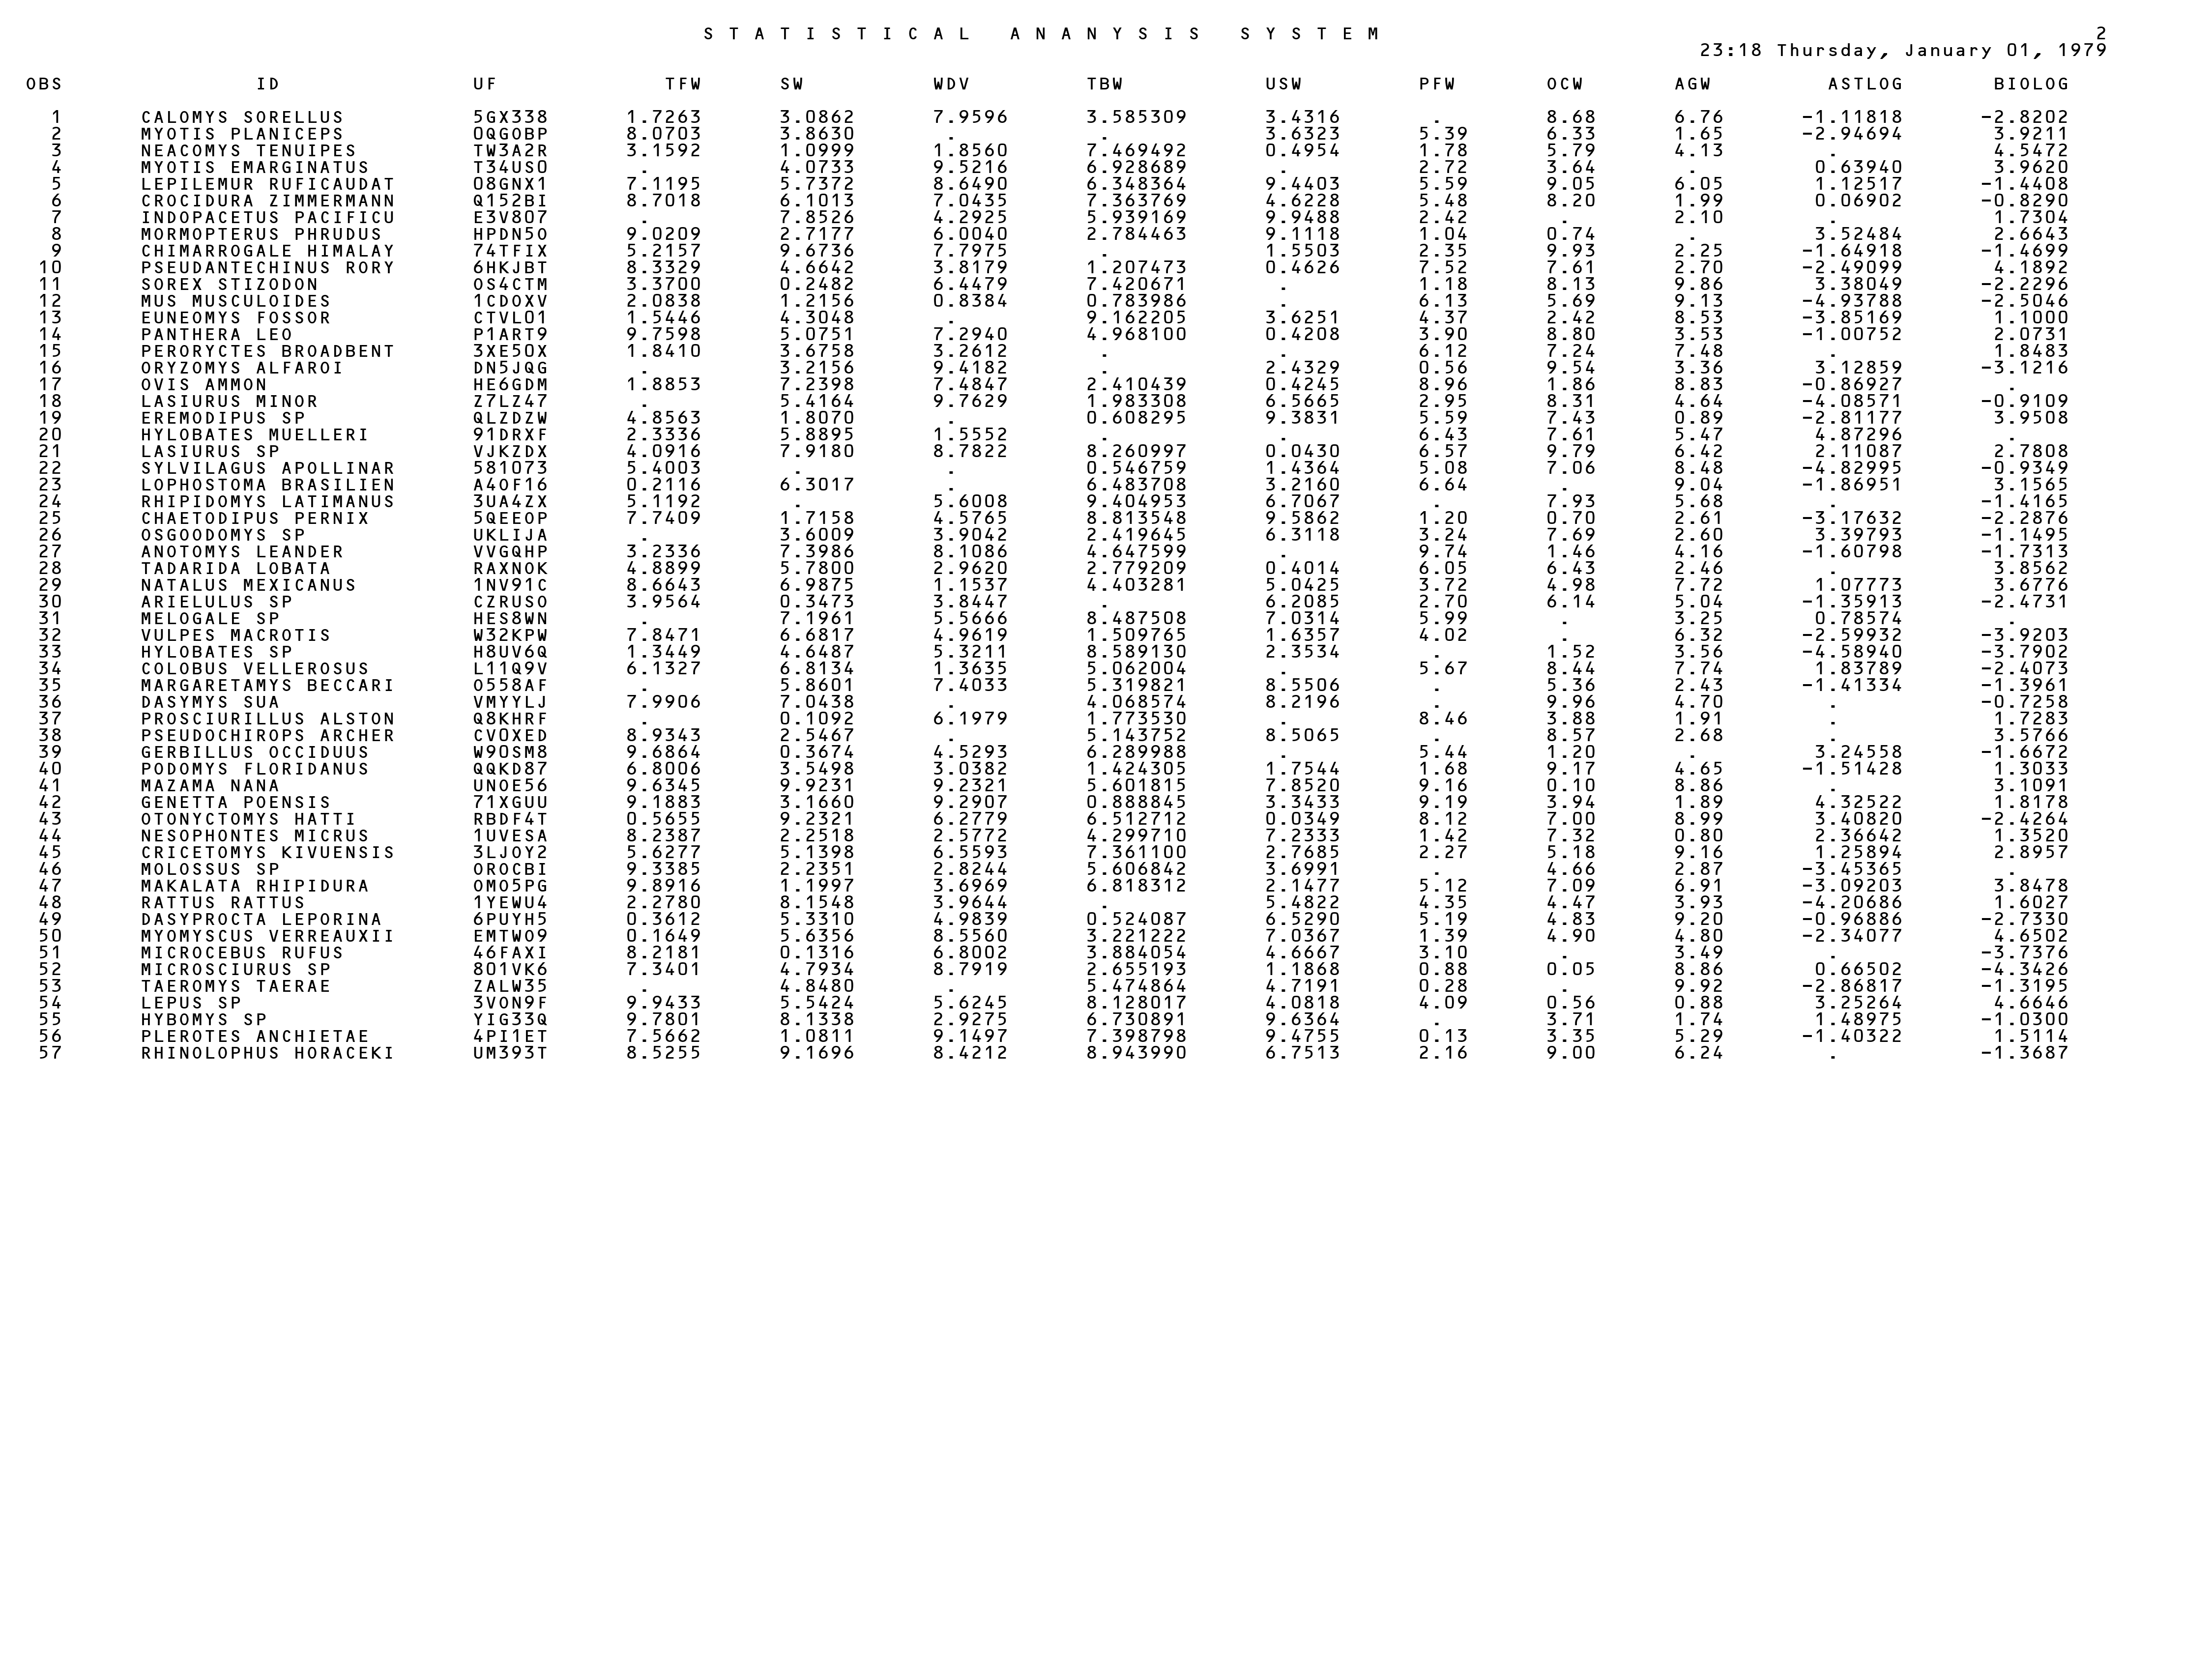

In [17]:
width = 4500
height = 3400

font = ImageFont.truetype('../fonts/OCRB Regular.ttf', 36)

image = Image.new(mode='L', size=(width, height), color='white')

draw = ImageDraw.Draw(image)

draw.text((50, 50), page, font=font, fill='black')

image.save(CLEAN_DIR / 'test.jpg', 'JPEG')

display(image)

## Sully the image

A function to change random values in a numpy array.

In [18]:
def add_snow(image, fract=0.1, low=128, high=255):
    shape = image.shape
    image = image.flatten()
    how_many = int(image.size * fract)
    mask = np.random.choice(image.size, how_many)
    image[mask] = np.random.randint(low, high)
    image = image.reshape(shape)
    return image

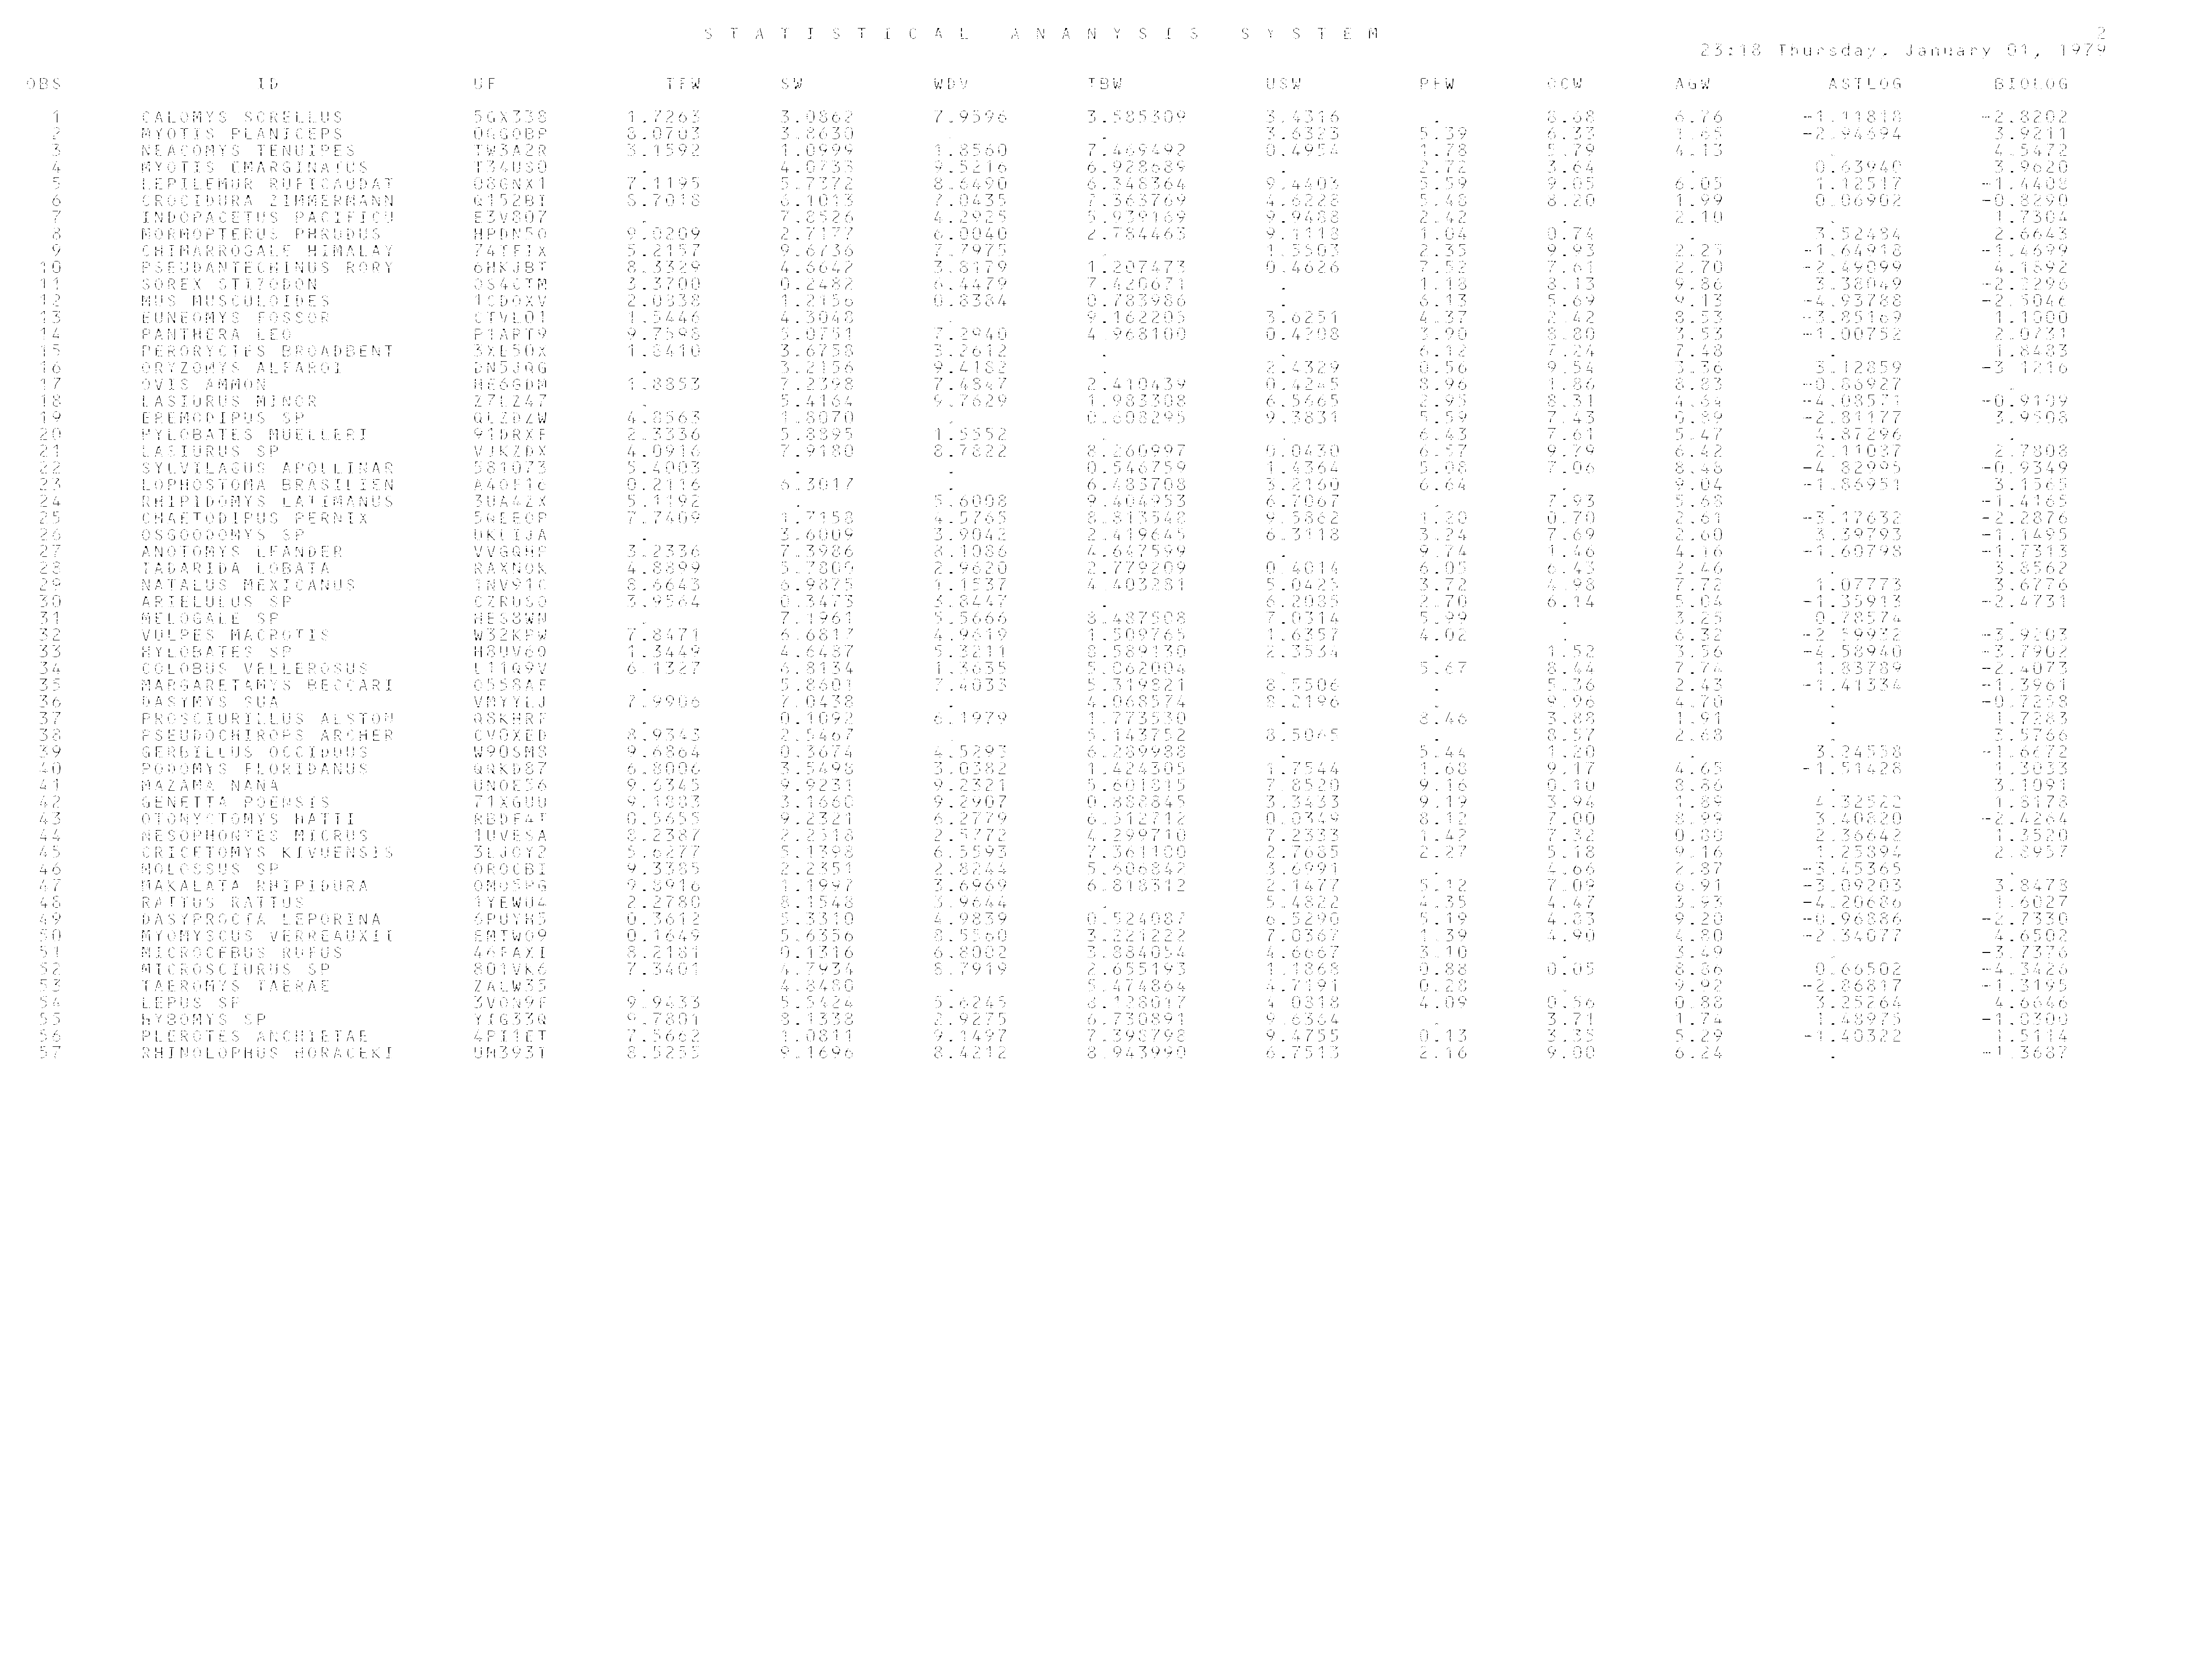

In [19]:
# kernel = np.array([
#     [-1, -1, -1],
#     [-1,  8, -1],
#     [-1, -1, -1],
# ])
# dirty = image.filter(ImageFilter.Kernel(size=(3, 3), kernel=kernel.flatten(), scale=0.1))

dirty = np.array(image)
dirty = add_snow(dirty, fract=0.05)
dirty = Image.fromarray(dirty)

dirty = dirty.filter(ImageFilter.UnsharpMask())
dirty = dirty.filter(ImageFilter.MaxFilter())

dirty = dirty.convert('RGB')

dirty.save(DIRTY_DIR / 'test.jpg', 'JPEG')

display(dirty)